In [2]:
import numpy as np
import scipy
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense
from keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

In [3]:
def lookup_limits():
    
    #Define the limits in all variables
    limits={
        'u-g'  : [-3,5],
        'g-r'  : [-11,4],
        'r-i'  : [-13,11],
        'i-z'  : [-12,12]
    }

    return limits

def rescale(x,var):
    
    #Rescale variable sample x of variable var between -1 and 1
    limits=lookup_limits()
    if var not in limits:
        raise ValueError

    return 1-2*(np.array(x)-min(limits[var]))/(max(limits[var])-min(limits[var]))

def split_datatest(sources):

    train={}
    test={}
    for k in train_var+['type']:
        train[k],test[k] = train_test_split(sources[k], test_size=0.3, random_state=0)
    return train,test

def nnet_in(sources):
    
    #Prepare neural network inputs.
    return np.array([rescale(sources[k],k) for k in train_var]).T

def nnet_out(sources, which='detnetwork'):
    
    #Prepare neural network outputs.    
    return sources['type']

def trainnetwork(train_s,test_s):

    train_in  = nnet_in(train_s)
    train_out = nnet_out(train_s)
    test_in  = nnet_in(test_s)
    test_out = nnet_out(test_s)

    my_init = keras.initializers.glorot_uniform(seed=1)
    
    model = keras.Sequential([
        # Input layer, do not change
        tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
        # Inner layers, can add/change
        keras.layers.Dense(5,  activation='relu',kernel_initializer=my_init),
        # Output layer, do not change
        keras.layers.Dense(1, kernel_initializer=my_init)])

    model.compile(
        # Optimization algorithm, specify learning rate
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        # Loss function for a binary classifier
        loss='binary_crossentropy',
        # Diagnostic quantities
        metrics=['accuracy'])

    # Actual Training
    history = model.fit(train_in, train_out, validation_data=(test_in, test_out),
                        epochs=100,
                        shuffle=True,
                        verbose=False)
    return model

def create_model(activation='relu', optimizer='Adam', lr=0.001):
    my_init = keras.initializers.glorot_uniform(seed=1)
    model = keras.Sequential()
    model.add(Dense(5, input_shape=(4,), activation=activation, kernel_initializer=my_init))
    model.add(Dense(1, kernel_initializer=my_init))

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])
    K.set_value(model.optimizer.learning_rate, lr)

    return model


In [4]:
data_ = pd.read_csv("galaxyquasar.csv", sep = ',')
train_var = ['u-g','g-r','r-i', 'i-z']
data = {}
data.update({'u-g': np.array(data_['u'] - data_['g'])})
data.update({'g-r': np.array(data_['g'] - data_['r'])})
data.update({'r-i': np.array(data_['r'] - data_['i'])})
data.update({'i-z': np.array(data_['i'] - data_['z'])})
label = np.array(data_['class'])
label[label == 'QSO'] = 1
label[label == 'GALAXY'] = 0
data.update({'type': label.astype(int)})

train_s,test_s = split_datatest(data)
X_train = nnet_in(train_s)
y_train = nnet_out(train_s)
X_test = nnet_in(test_s)
y_test = nnet_out(test_s)

First thing I do is to train the Tensorflow classifier, using a network architecture with a single hidden layer with 5 neurons, using the adam solver, the relu activation function, and a learninig rate of 0.001.

In [5]:
train_reduced={}
for k in ['u-g','g-r','r-i', 'i-z','type']:
    train_reduced[k]=train_s[k][:1000]
model = trainnetwork(train_reduced, test_s)

2024-01-28 13:45:08.171667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-28 13:45:08.171688: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-28 13:45:08.171703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-ubuntu): /proc/driver/nvidia/version does not exist
2024-01-28 13:45:08.171894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
y_prob = np.squeeze(model.predict(nnet_in(test_s)))
y_pred = np.squeeze((y_prob > 0.5).astype("int32"))

469/469 [==============================] - 0s 411us/step


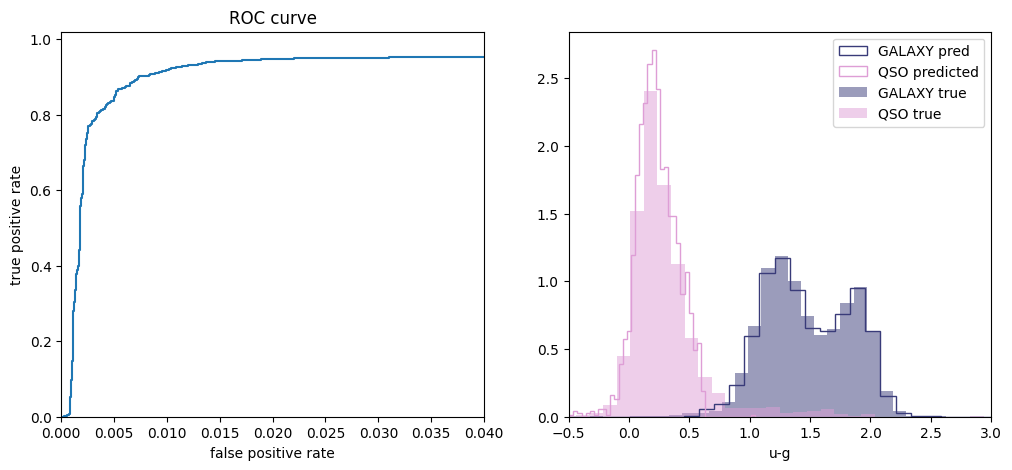

In [7]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
fpr, tpr, thresh = roc_curve(y_test, y_prob)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
ax1.plot(fpr, tpr)
ax1.set_title('ROC curve')
ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')

ax2.hist(test_s['u-g'][y_pred==0], bins=50, density=True, histtype='step', color=plt.cm.get_cmap('tab20b')(0), label='GALAXY pred')
ax2.hist(test_s['u-g'][y_pred==1], bins=50, density=True, histtype='step', color=plt.cm.get_cmap('tab20b')(20), label='QSO predicted')
ax2.hist(test_s['u-g'][y_test==0], bins=50, density=True, color=plt.cm.get_cmap('tab20b')(0), label='GALAXY true', alpha=0.5)
ax2.hist(test_s['u-g'][y_test==1], bins=50, density=True, color=plt.cm.get_cmap('tab20b')(20), label='QSO true', alpha=0.5)
ax2.legend()
ax2.set_xlabel('u-g')
ax2.set_xlim(-0.5,3)
plt.show()

### Cross validation
I do a cross validation test on some hyperparameters : optimizer (SGD, Adam), activation (tanh, relu), epochs (50,100,150), learning rate (0.0001, 0.001, 0.01)

In [8]:
kears_estimator = KerasClassifier(build_fn=create_model, verbose=False)
optimizer = ['SGD', 'Adam']
activation = ['tanh', 'relu']
learn_rate = [0.0001, 0.001, 0.01]
epochs = [50, 100, 150]
param_grid = dict(epochs=epochs, activation=activation, optimizer=optimizer, lr=learn_rate)
grid = GridSearchCV(estimator=kears_estimator, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train[:1000], y_train[:1000])

2024-01-28 13:45:34.858289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 13:45:34.862460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 13:45:34.890504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, reb

2024-01-28 13:45:35.277940: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 13:45:35.281471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 13:45:35.281503: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-28 13:45:35.787217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-28 13:45:35.787443: W tensorflow/compiler/xla

2024-01-28 13:45:36.235927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-28 13:45:36.236021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-28 13:45:36.236035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2024-01-28 13:45:36.254499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory


2024-01-28 13:45:37.355857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-28 13:45:37.355895: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-28 13:45:37.355915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-ubuntu): /proc/driver/nvidia/version does not exist
2024-01-28 13:45:37.356151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
print("Best hyperparameters : %s" % (grid_result.best_params_))
best_model = grid.best_estimator_

Best hyperparameters : {'activation': 'relu', 'epochs': 100, 'lr': 0.01, 'optimizer': 'Adam'}


In [10]:
best_model.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True, verbose=False)

In [11]:
y_prob_best = np.squeeze(best_model.predict_proba(X_test)[:,1])
y_pred_best = np.squeeze(best_model.predict(X_test))

469/469 [==============================] - 0s 322us/step


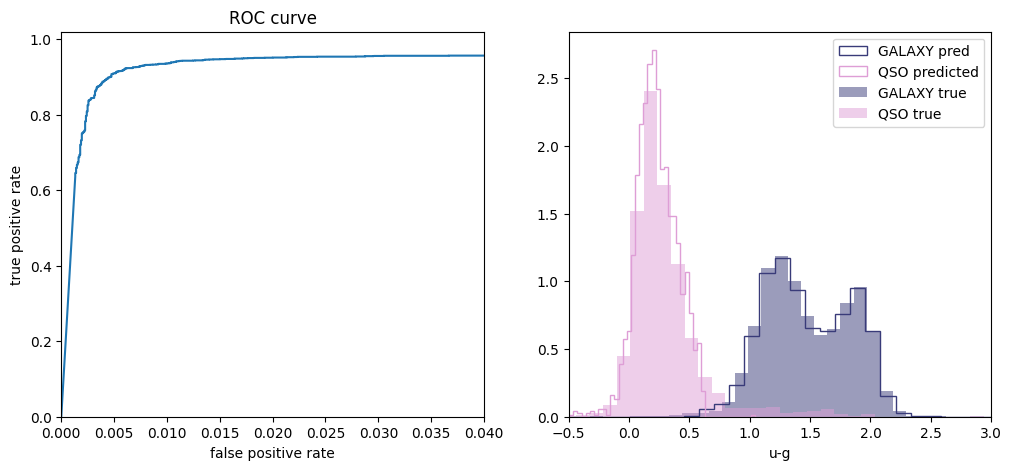

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
fpr, tpr, thresh = roc_curve(y_test, y_prob_best)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
ax1.plot(fpr, tpr)
ax1.set_title('ROC curve')
ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')

ax2.hist(test_s['u-g'][y_pred==0], bins=50, density=True, histtype='step', color=plt.cm.get_cmap('tab20b')(0), label='GALAXY pred')
ax2.hist(test_s['u-g'][y_pred==1], bins=50, density=True, histtype='step', color=plt.cm.get_cmap('tab20b')(20), label='QSO predicted')
ax2.hist(test_s['u-g'][y_test==0], bins=50, density=True, color=plt.cm.get_cmap('tab20b')(0), label='GALAXY true', alpha=0.5)
ax2.hist(test_s['u-g'][y_test==1], bins=50, density=True, color=plt.cm.get_cmap('tab20b')(20), label='QSO true', alpha=0.5)
ax2.legend()
ax2.set_xlabel('u-g')
ax2.set_xlim(-0.5,3)
plt.show()

In [13]:
print('Accuracy before CV : ', accuracy_score(y_pred,y_test))
print('Accuracy after CV : ', accuracy_score(y_pred_best,y_test))

Accuracy before CV :  0.9794666666666667
Accuracy after CV :  0.9836
